In [43]:
import numpy as np 
import pandas as pd 
import sklearn as sk 
import matplotlib.pyplot as plt
from typing import Tuple
import glob

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor, XGBClassifier

from scipy.signal import find_peaks, peak_prominences

import torch 
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset, random_split, DataLoader
import torch.optim as optim

#moved everything out
from utils import visualize, percent_healthy, get_glucose_response, discretize

In [44]:
##load everything in 
paths = glob.glob(r"../../CGMacros/CGMacros-*/CGMacros-*.csv", recursive=True)
df = pd.read_csv(paths[0]).fillna(0)

#get glucose response for all participants
mldf = get_glucose_response(df, unhealthy=False, discrete=False) #unhealthy false, discrete flase default
for path in paths:
    df = pd.read_csv(path).fillna(0)
    ml = get_glucose_response(df, unhealthy=False, discrete=False)
    
    mldf = pd.concat([mldf, ml], axis = 0)

In [45]:
lib = mldf["lib_prom"]
dex = mldf["dex_prom"]

np.corrcoef(lib, dex)

array([[1.        , 0.73544797],
       [0.73544797, 1.        ]])

In [ ]:
#create new dataset with both and device indicator


In [ ]:
class SpikeDataset(Dataset):
    def __init__(self, macros, spike):
        self.macros = macros.reset_index(drop=True) #vector of macro values (carbs, protein, fiber, fats, calories)
        self.spike = spike.reset_index(drop=True) #R1 collected spike value (mg/dL)
    
    def __len__(self):
        return len(self.spike)
    
    def __getitem__(self, idx):
        meal = torch.tensor(self.macros.iloc[idx, :], dtype = torch.float32) #wrap in tensors
        response = torch.tensor([self.spike[idx]], dtype = torch.float32) #expects 1d, not scalar 
        return meal, response #X, y

#make two different datasets for libre and dexcome data
SD_lib = SpikeDataset(mldf[["Calories", "Carbs", "Protein", "Fiber", "Fat"]], mldf["lib_prom"])
SD_dex = SpikeDataset(mldf[["Calories", "Carbs", "Protein", "Fiber", "Fat"]], mldf["dex_prom"])


In [47]:
#split cwt_data (Dataset) into 80 20 train/test split
data_len = len(SD_lib)
train_size = int(0.8 * data_len)
test_size = len(SD_lib) - train_size

train_dataset, test_dataset = random_split(SD_lib, [train_size, test_size])

train_dataset, test_dataset = random_split(SD_lib, [0.8, 0.2])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle = False)

In [48]:
#K.I.S.S!
class MacroNN(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.l1 = nn.Linear(5, 32) #5 macros
        self.l2 = nn.Linear(32, 16)
        self.l3 = nn.Linear(16, 8)
        self.l4 = nn.Linear(8, 1) #regression, use raw logit
        
    
    def forward(self, x): #define forward pass i.e. how does the model handle inputs?
        
        x = F.relu(self.l1(x))
        x = F.relu(self.l2(x))
        x = F.relu(self.l3(x))
        x = self.l4(x)
        
        return x

model = MacroNN()


In [51]:
#define additional hyperparameters
#loss = nn.MSELoss()
loss = torch.nn.SmoothL1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_track = []

EPOCHS = 500 
for epoch in range(EPOCHS):
    
    total_loss = 0.0
    
    for i, data in enumerate(train_loader, 0):
        X, y = data
        optimizer.zero_grad() #zero out gradients so weights aren't misadjusted
        
        out = model(X)
        loss_val = loss(out, y) #MSE loss calculated with output and y 
        
        loss_val.backward() #backpropataion
        optimizer.step() #adjust weights based on backpropagation
        
        total_loss += loss_val.item()
        #print(f"loss: {loss_val.item()}")
        
    loss_track.append(total_loss / len(train_loader))
        
print("finished training")

finished training


note Huber loss is quadratic close to 0, and absval/linear away from zero --> less sensitive to outliers

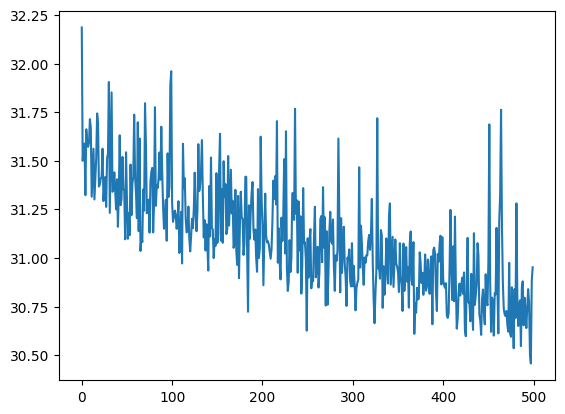

In [ ]:
plt.plot(loss_track)
plt.title("Huber Loss v.s Training Epochs")
plt.xlabel("Epoch")
plt.ylabel("Huber Smooth L1 Loss")